In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
from matplotlib import pyplot as plt
import networkx as nx
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset

Set cells width

In [99]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [100]:
INPUT_PATH = "../../data/email-Eu-core-temporal.txt.gz"

Load the dataset

In [101]:
dataset = Dataset(INPUT_PATH, top=100, timescale='median')

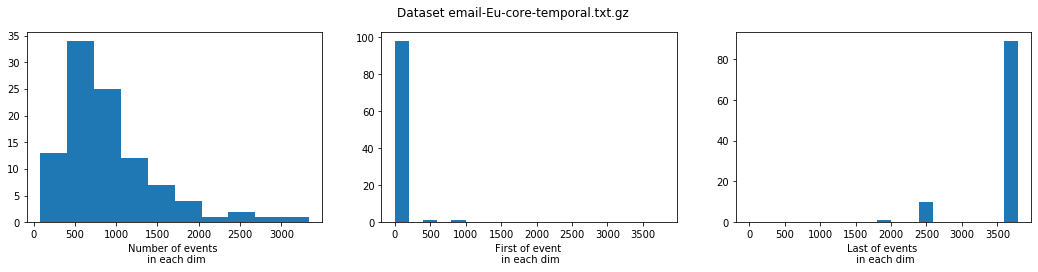

In [102]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)))
axs[0].set_xlabel('Number of events \n in each dim')

end_time = dataset.end_time
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}");

Print statistics of the dataset

In [103]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 92,924
               %NZ: 26.23%

Stats. of num. of events per dim:
count     100.000000
mean      929.240000
std       589.331261
min        82.000000
25%       544.000000
50%       770.000000
75%      1210.000000
max      3334.000000
dtype: float64


#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

Busca estimators of **beta_j**:
count    100.000000
mean       1.047821
std        1.697593
min        0.027073
25%        0.290703
50%        0.556093
75%        0.916578
max       13.945126
dtype: float64
Median: 0.5560928243605474


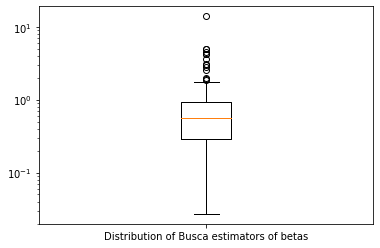

In [104]:
busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) for ev in events])
plt.boxplot(busca_betas, labels=['Distribution of Busca estimators of betas']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print('Median:', np.median(busca_betas))

Busca estimators of **beta_{ij}**:
count    10000.000000
mean         1.218508
std          2.322191
min          0.000000
25%          0.344152
50%          1.004831
75%          1.474058
max        118.573898
dtype: float64
Median: 1.0048314332962036


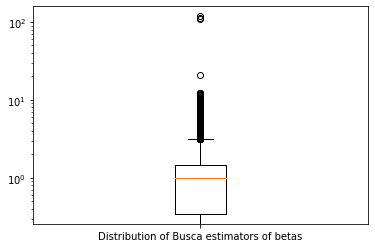

In [105]:
wold_model = tsvar.models.WoldModel()
wold_model.observe(events)
busca_beta_ji = np.zeros((wold_model.dim, wold_model.dim))
for i in range(wold_model.dim):
    busca_beta_ji[:, i] = np.median(wold_model.delta_ikj[i][:, :], axis=0) / np.exp(1)
del wold_model

plt.boxplot(busca_beta_ji.flatten(), labels=['Distribution of Busca estimators of betas']);
plt.yscale('log')
print('Busca estimators of **beta_{ij}**:')
print(pd.Series(busca_beta_ji.flatten()).describe())
print('Median:', np.median(busca_beta_ji))

#### Filter dimensions and rescale time

In [31]:
graph = graph.subgraph(nodes_to_keep)
events = [torch.tensor(ev, dtype=torch.float) / 18413.4697265625 for i, ev in enumerate(dataset.timestamps) if i in nodes_to_keep]

In [32]:
print(f"Num. of dimensions: {len(events):,d}")
print(f"    Num. of events: {sum(map(len, events)):,d}")
print(f"               %NZ: {100 * graph.number_of_edges() / (graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, events)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 92,924
               %NZ: 26.23%

Stats. of num. of events per dim:
count     100.000000
mean      929.240000
std       589.331261
min        82.000000
25%       544.000000
50%       770.000000
75%      1210.000000
max      3334.000000
dtype: float64


Build ground truth adjacency matrix

In [108]:
adjacency_true = nx.adjacency_matrix(graph).toarray()
adjacency_true = adjacency_true / adjacency_true.max()

Recompute the Busca estimators of betas

In [34]:
wold_model = tsvar.models.WoldModel()
wold_model.observe(events)

busca_beta_ji = np.zeros((wold_model.dim, wold_model.dim))
for i in range(wold_model.dim):
    busca_beta_ji[:, i] = np.median(wold_model.delta_ikj[i][:, :], axis=0) / np.exp(1)
    
del wold_model

count    10000.000000
mean         1.212515
std          2.310579
min          0.000000
25%          0.342555
50%          1.000009
75%          1.466758
max        117.979324
dtype: float64
Median: 1.0000094771385193


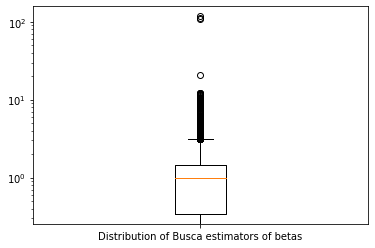

In [35]:
plt.boxplot(busca_beta_ji.flatten(), labels=['Distribution of Busca estimators of betas']);
plt.yscale('log')
print(pd.Series(busca_beta_ji.flatten()).describe())
print('Median:', np.median(busca_beta_ji))

---

## Run inference

---

### Run BBVI

In [ ]:
dim = len(events)
n_params = dim + dim**2 + dim**2
end_time = max(map(max, events))

# Set initial guess
coeffs_start = torch.tensor(np.hstack((
    # loc
    -2.0 * torch.ones(dim, dtype=torch.float),                  # baseline
    0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # beta
    0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # adjacency
    # scale
    torch.log(0.2 * torch.ones(dim, dtype=torch.float)),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
)))

# Define priors/posteriors
posterior = tsvar.posteriors.LogNormalPosterior
prior = tsvar.priors.GaussianLaplacianPrior
mask_gaus = torch.zeros(n_params, dtype=torch.bool)
mask_gaus[:dim + dim**2] = 1  # Gaussian prior for baseline and beta
C = 1e3

# Init the model object
model = tsvar.models.WoldModelBBVI(posterior=posterior, prior=prior, C=C,
                                   prior_kwargs={'mask_gaus': mask_gaus},
                                   n_samples=1, n_weights=1, weight_temp=1,
                                   verbose=False, device='cpu')
model.observe(events, end_time)

# Set link function for callback (vi coeffs -> posterior mode)
def link_func(coeffs):
    """variationa coeffs -> posterior mode of adjacency"""
    # Numpy to torch
    coeffs = torch.tensor(coeffs) if isinstance(coeffs, np.ndarray) else coeffs
    return model.posterior.mode(
        coeffs[:model.n_params], coeffs[model.n_params:]
    ).detach().numpy()[dim:dim+dim**2]

# Set the callback (callback parameters are posterior mode)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=posterior().mode(
        coeffs_start[:dim+2*dim**2], coeffs_start[dim+2*dim**2:]
    )[dim:dim+dim**2],
    print_every=10,
    coeffs_true=adjacency_true,
    acc_thresh=0.05,
    dim=dim,
    link_func=link_func,
    default_end='\n')

# Fit the model
conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=1e-1,
                 lr_sched=0.9999, tol=1e-6, max_iter=20000,
                 mstep_interval=100, mstep_offset=500, mstep_momentum=0.5,
                 seed=None, callback=callback)

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:])
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

In [ ]:
sum(adj_hat >= THRESH)

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

adj_hat = adj_hat / beta_hat

THRESH = 0.01

acc = tsvar.utils.metrics.accuracy(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
fsc = tsvar.utils.metrics.fscore(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
relerr = tsvar.utils.metrics.relerr(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten())
precat5 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=5)
precat10 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=10)
precat20 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=20)

prec = tsvar.utils.metrics.precision(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
rec = tsvar.utils.metrics.recall(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)

print(f"Accuracy: {acc:.2f}")
print(f"F1-Score: {fsc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"Prec@5: {precat5:.2f}")
print(f"Prec@10: {precat10:.2f}")
print(f"Prec@20: {precat20:.2f}")

print()
for k in [5, 10, 20]:
    print(k, tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat >= THRESH, A_true=adjacency_true, k=k))

---

### Run VI-fb

In [39]:
dim = len(events)

# Set priors
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

zc_pr = [1.0 * np.ones((len(ev), dim+1)) for ev in events]

beta = 1.0 * np.ones((dim, dim))
#beta = busca_beta_ji

In [40]:
# Set model
vifb_model = tsvar.models.WoldModelVariationalFixedBeta(verbose=True)
vifb_model.observe(events, beta=busca_beta_ji)

In [42]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr / ar_pr).flatten(), print_every=10,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
conv = vifb_model.fit(as_pr=as_pr, ar_pr=ar_pr, zc_pr=zc_pr, max_iter=5000,
                 tol=1e-5, callback=callback)
print('Converged?', conv)

iter:    10 | dx: +2.9086e-01 | f1-score: 0.11 | relerr: 4.51e+01 | p@5: 0.40 | p@10: 0.40 | p@20: 0.25 | time/it: 2.57e-01     
iter:    20 | dx: +1.1832e-01 | f1-score: 0.10 | relerr: 5.08e+01 | p@5: 0.40 | p@10: 0.40 | p@20: 0.20 | time/it: 2.46e-01     
iter:    30 | dx: +3.8161e-02 | f1-score: 0.10 | relerr: 5.23e+01 | p@5: 0.40 | p@10: 0.40 | p@20: 0.20 | time/it: 2.18e-01     
iter:    40 | dx: +2.0895e-02 | f1-score: 0.10 | relerr: 5.25e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.19e-01     
iter:    50 | dx: +1.4363e-02 | f1-score: 0.10 | relerr: 5.24e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.18e-01     
iter:    60 | dx: +8.9466e-03 | f1-score: 0.09 | relerr: 5.23e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.22e-01     
iter:    70 | dx: +4.6922e-03 | f1-score: 0.09 | relerr: 5.22e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.20e-01     
iter:    80 | dx: +4.0166e-03 | f1-score: 0.09 | relerr: 5.21e+01 | p@5: 0.40 | p@10: 0.30 | p@20

iter:   650 | dx: +2.6022e-04 | f1-score: 0.09 | relerr: 5.17e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.83e-01     
iter:   660 | dx: +3.2788e-04 | f1-score: 0.09 | relerr: 5.17e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.35e-01     
iter:   670 | dx: +4.2898e-04 | f1-score: 0.09 | relerr: 5.17e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.18e-01     
iter:   680 | dx: +5.7564e-04 | f1-score: 0.09 | relerr: 5.17e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.18e-01     
iter:   690 | dx: +2.4174e-04 | f1-score: 0.09 | relerr: 5.17e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.18e-01     
iter:   700 | dx: +2.5262e-04 | f1-score: 0.09 | relerr: 5.17e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.17e-01     
iter:   710 | dx: +2.6720e-04 | f1-score: 0.09 | relerr: 5.17e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.17e-01     
iter:   720 | dx: +2.8339e-04 | f1-score: 0.09 | relerr: 5.17e+01 | p@5: 0.40 | p@10: 0.30 | p@20

iter:  1290 | dx: +9.0892e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.18e-01     
iter:  1300 | dx: +1.1125e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.19e-01     
iter:  1310 | dx: +1.1365e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.19e-01     
iter:  1320 | dx: +1.9848e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.19e-01     
iter:  1330 | dx: +1.3169e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.22e-01     
iter:  1340 | dx: +9.5850e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.20e-01     
iter:  1350 | dx: +1.1274e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.16e-01     
iter:  1360 | dx: +1.0943e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20

iter:  1930 | dx: +1.2591e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.48e-01     
iter:  1940 | dx: +1.1265e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.32e-01     
iter:  1950 | dx: +1.1985e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.33e-01     
iter:  1960 | dx: +1.1392e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.36e-01     
iter:  1970 | dx: +1.1924e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.76e-01     
iter:  1980 | dx: +1.3338e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.61e-01     
iter:  1990 | dx: +1.2361e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.39e-01     
iter:  2000 | dx: +1.1095e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20

iter:  2570 | dx: +8.1992e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.23e-01     
iter:  2580 | dx: +1.0758e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.36e-01     
iter:  2590 | dx: +1.3471e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.33e-01     
iter:  2600 | dx: +9.2128e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.44e-01     
iter:  2610 | dx: +1.0343e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.30e-01     
iter:  2620 | dx: +8.5590e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.24e-01     
iter:  2630 | dx: +9.1292e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.19e-01     
iter:  2640 | dx: +1.3852e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20

iter:  3210 | dx: +9.3144e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.31e-01     
iter:  3220 | dx: +1.8289e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.24e-01     
iter:  3230 | dx: +7.1027e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.43e-01     
iter:  3240 | dx: +9.9547e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.46e-01     
iter:  3250 | dx: +1.5689e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.21e-01     
iter:  3260 | dx: +1.3856e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.38e-01     
iter:  3270 | dx: +1.4698e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.41e-01     
iter:  3280 | dx: +5.4618e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20

iter:  3850 | dx: +7.6684e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.29e-01     
iter:  3860 | dx: +1.3698e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.29e-01     
iter:  3870 | dx: +1.0501e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.27e-01     
iter:  3880 | dx: +5.8808e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.31e-01     
iter:  3890 | dx: +9.8734e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.27e-01     
iter:  3900 | dx: +1.2333e-04 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.27e-01     
iter:  3910 | dx: +5.1908e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 2.26e-01     
iter:  3920 | dx: +7.2627e-05 | f1-score: 0.09 | relerr: 5.16e+01 | p@5: 0.40 | p@10: 0.30 | p@20

KeyboardInterrupt: 

In [120]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]
mu_hat = vifb_model._as_po[0, :] / vifb_model._ar_po[0, :]

adj_hat = adj_hat / beta

THRESH = 0.05

acc = tsvar.utils.metrics.accuracy(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
fsc = tsvar.utils.metrics.fscore(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
relerr = tsvar.utils.metrics.relerr(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten())
precat5 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=5)
precat10 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=10)
precat20 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=20)

prec = tsvar.utils.metrics.precision(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
rec = tsvar.utils.metrics.recall(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)

print(f"Accuracy: {acc:.2f}")
print(f"F1-Score: {fsc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"Prec@5: {precat5:.2f}")
print(f"Prec@10: {precat10:.2f}")
print(f"Prec@20: {precat20:.2f}")

print()
for k in [5, 10, 20]:
    print(k, tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat, A_true=adjacency_true, k=k))

Accuracy: 0.71
F1-Score: 0.09
Precision: 0.25
Recall: 0.06
Prec@5: 0.40
Prec@10: 0.30
Prec@20: 0.20

5 0.054545454545454564
10 0.09797979797979789
20 0.2070707070707071


---

### Run VI

In [55]:
dim = len(events)

# Set priors
# prior: Alpha
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr[0,0] / ar_pr[0,0])
print('variance')
print(as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance')
print(br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
0.1
variance
0.1
BETA:
-----
mean
1.1111111111111112
variance
0.15432098765432098


In [56]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariational(verbose=True)
vi_model.observe(events)

In [57]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=1,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=2500, tol=1e-5, callback=callback)

iter:     1 | dx: +9.9617e-02 | f1-score: 0.01 | relerr: 1.94e+01 | p@5: 0.20 | p@10: 0.40 | p@20: 0.35 | time/it: 2.82e+01     
iter:     2 | dx: +6.6269e-02 | f1-score: 0.02 | relerr: 2.24e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.40 | time/it: 1.11e+00     
iter:     3 | dx: +7.6567e-02 | f1-score: 0.02 | relerr: 2.17e+01 | p@5: 0.60 | p@10: 0.30 | p@20: 0.30 | time/it: 1.08e+00     
iter:     4 | dx: +1.1018e-01 | f1-score: 0.03 | relerr: 2.19e+01 | p@5: 0.60 | p@10: 0.30 | p@20: 0.35 | time/it: 1.03e+00     
iter:     5 | dx: +1.3309e-01 | f1-score: 0.03 | relerr: 2.22e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 1.02e+00     
iter:     6 | dx: +1.3564e-01 | f1-score: 0.04 | relerr: 2.26e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 1.01e+00     
iter:     7 | dx: +1.1590e-01 | f1-score: 0.05 | relerr: 2.28e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.20 | time/it: 9.95e-01     
iter:     8 | dx: +8.2434e-02 | f1-score: 0.06 | relerr: 2.29e+01 | p@5: 0.40 | p@10: 0.30 | p@20

iter:    65 | dx: +8.0882e-02 | f1-score: 0.09 | relerr: 2.46e+01 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 8.36e-01     
iter:    66 | dx: +8.3868e-02 | f1-score: 0.09 | relerr: 2.47e+01 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 8.56e-01     
iter:    67 | dx: +8.6890e-02 | f1-score: 0.09 | relerr: 2.47e+01 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 8.50e-01     
iter:    68 | dx: +8.9561e-02 | f1-score: 0.09 | relerr: 2.48e+01 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 8.25e-01     
iter:    69 | dx: +9.2537e-02 | f1-score: 0.09 | relerr: 2.49e+01 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 8.22e-01     
iter:    70 | dx: +9.4957e-02 | f1-score: 0.09 | relerr: 2.50e+01 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 8.22e-01     
iter:    71 | dx: +9.7304e-02 | f1-score: 0.09 | relerr: 2.51e+01 | p@5: 0.40 | p@10: 0.20 | p@20: 0.25 | time/it: 8.24e-01     
iter:    72 | dx: +9.9952e-02 | f1-score: 0.09 | relerr: 2.52e+01 | p@5: 0.40 | p@10: 0.20 | p@20

iter:   129 | dx: +4.2806e-02 | f1-score: 0.09 | relerr: 2.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.20 | time/it: 8.21e-01     
iter:   130 | dx: +4.2919e-02 | f1-score: 0.09 | relerr: 2.98e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.20 | time/it: 8.10e-01     
iter:   131 | dx: +4.3064e-02 | f1-score: 0.09 | relerr: 2.99e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 8.10e-01     
iter:   132 | dx: +4.3146e-02 | f1-score: 0.09 | relerr: 2.99e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 8.04e-01     
iter:   133 | dx: +4.3256e-02 | f1-score: 0.09 | relerr: 3.00e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 8.15e-01     
iter:   134 | dx: +4.3410e-02 | f1-score: 0.09 | relerr: 3.00e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 8.09e-01     
iter:   135 | dx: +4.3413e-02 | f1-score: 0.09 | relerr: 3.01e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 8.03e-01     
iter:   136 | dx: +4.3452e-02 | f1-score: 0.09 | relerr: 3.01e+01 | p@5: 0.20 | p@10: 0.20 | p@20

iter:   193 | dx: +2.2456e-02 | f1-score: 0.09 | relerr: 3.19e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 7.99e-01     
iter:   194 | dx: +2.1889e-02 | f1-score: 0.09 | relerr: 3.19e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 8.01e-01     
iter:   195 | dx: +2.1529e-02 | f1-score: 0.09 | relerr: 3.20e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 7.96e-01     
iter:   196 | dx: +2.1140e-02 | f1-score: 0.09 | relerr: 3.20e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 8.20e-01     
iter:   197 | dx: +2.0640e-02 | f1-score: 0.09 | relerr: 3.20e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 8.11e-01     
iter:   198 | dx: +2.0335e-02 | f1-score: 0.09 | relerr: 3.20e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 8.04e-01     
iter:   199 | dx: +1.9898e-02 | f1-score: 0.09 | relerr: 3.20e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 8.08e-01     
iter:   200 | dx: +1.9532e-02 | f1-score: 0.09 | relerr: 3.21e+01 | p@5: 0.00 | p@10: 0.20 | p@20

iter:   257 | dx: +1.8606e-02 | f1-score: 0.09 | relerr: 3.29e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 8.08e-01     
iter:   258 | dx: +1.8526e-02 | f1-score: 0.09 | relerr: 3.29e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 7.99e-01     
iter:   259 | dx: +1.8417e-02 | f1-score: 0.09 | relerr: 3.29e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 8.12e-01     
iter:   260 | dx: +1.8307e-02 | f1-score: 0.09 | relerr: 3.30e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 8.00e-01     
iter:   261 | dx: +1.8154e-02 | f1-score: 0.09 | relerr: 3.30e+01 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 8.03e-01     
iter:   262 | dx: +1.8069e-02 | f1-score: 0.09 | relerr: 3.30e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.13e-01     
iter:   263 | dx: +1.7875e-02 | f1-score: 0.09 | relerr: 3.30e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.02e-01     
iter:   264 | dx: +1.7720e-02 | f1-score: 0.09 | relerr: 3.30e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   321 | dx: +8.0525e-03 | f1-score: 0.09 | relerr: 3.35e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.08e-01     
iter:   322 | dx: +7.9367e-03 | f1-score: 0.09 | relerr: 3.35e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.95e-01     
iter:   323 | dx: +7.8663e-03 | f1-score: 0.09 | relerr: 3.35e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.98e-01     
iter:   324 | dx: +7.6706e-03 | f1-score: 0.09 | relerr: 3.35e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.35e-01     
iter:   325 | dx: +7.5979e-03 | f1-score: 0.09 | relerr: 3.35e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.04e-01     
iter:   326 | dx: +7.4476e-03 | f1-score: 0.09 | relerr: 3.35e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.95e-01     
iter:   327 | dx: +7.3159e-03 | f1-score: 0.09 | relerr: 3.35e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.95e-01     
iter:   328 | dx: +7.1919e-03 | f1-score: 0.09 | relerr: 3.35e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   385 | dx: +3.4473e-03 | f1-score: 0.09 | relerr: 3.37e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.97e-01     
iter:   386 | dx: +3.4576e-03 | f1-score: 0.09 | relerr: 3.37e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.10e-01     
iter:   387 | dx: +3.1426e-03 | f1-score: 0.09 | relerr: 3.37e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.01e-01     
iter:   388 | dx: +2.8768e-03 | f1-score: 0.09 | relerr: 3.37e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.98e-01     
iter:   389 | dx: +2.8978e-03 | f1-score: 0.09 | relerr: 3.37e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.81e-01     
iter:   390 | dx: +2.9146e-03 | f1-score: 0.09 | relerr: 3.37e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.15e-01     
iter:   391 | dx: +2.9306e-03 | f1-score: 0.09 | relerr: 3.37e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.03e-01     
iter:   392 | dx: +2.9413e-03 | f1-score: 0.09 | relerr: 3.38e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   449 | dx: +3.5076e-03 | f1-score: 0.09 | relerr: 3.38e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.04e-01     
iter:   450 | dx: +3.4991e-03 | f1-score: 0.09 | relerr: 3.38e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.94e-01     
iter:   451 | dx: +3.5161e-03 | f1-score: 0.09 | relerr: 3.38e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.04e-01     
iter:   452 | dx: +3.5131e-03 | f1-score: 0.09 | relerr: 3.38e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.97e-01     
iter:   453 | dx: +3.5072e-03 | f1-score: 0.09 | relerr: 3.38e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.98e-01     
iter:   454 | dx: +3.5247e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.98e-01     
iter:   455 | dx: +3.5107e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.93e-01     
iter:   456 | dx: +3.5064e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   513 | dx: +2.9381e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.07e-01     
iter:   514 | dx: +2.9223e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.97e-01     
iter:   515 | dx: +2.8887e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.96e-01     
iter:   516 | dx: +2.8805e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.94e-01     
iter:   517 | dx: +2.8648e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.88e-01     
iter:   518 | dx: +2.8496e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.95e-01     
iter:   519 | dx: +2.8325e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.05e-01     
iter:   520 | dx: +2.8265e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   577 | dx: +1.7757e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.04e-01     
iter:   578 | dx: +1.7717e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.96e-01     
iter:   579 | dx: +1.7445e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.98e-01     
iter:   580 | dx: +1.7219e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.03e-01     
iter:   581 | dx: +1.7199e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.95e-01     
iter:   582 | dx: +1.7047e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.93e-01     
iter:   583 | dx: +1.6498e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.95e-01     
iter:   584 | dx: +1.6716e-03 | f1-score: 0.09 | relerr: 3.39e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   641 | dx: +9.1371e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.89e-01     
iter:   642 | dx: +9.0523e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.93e-01     
iter:   643 | dx: +8.9088e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.93e-01     
iter:   644 | dx: +8.7756e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.97e-01     
iter:   645 | dx: +8.9352e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.95e-01     
iter:   646 | dx: +8.7319e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.05e-01     
iter:   647 | dx: +8.5931e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.08e-01     
iter:   648 | dx: +8.6149e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   705 | dx: +7.3472e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.11e+00     
iter:   706 | dx: +7.3018e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.37e-01     
iter:   707 | dx: +7.5510e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.06e-01     
iter:   708 | dx: +7.8331e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.99e-01     
iter:   709 | dx: +6.6911e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.13e-01     
iter:   710 | dx: +7.2615e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.93e-01     
iter:   711 | dx: +1.1407e-03 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.95e-01     
iter:   712 | dx: +7.8600e-04 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   769 | dx: +1.9978e-03 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.83e-01     
iter:   770 | dx: +1.9786e-03 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.82e-01     
iter:   771 | dx: +1.9941e-03 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.84e-01     
iter:   772 | dx: +1.9014e-03 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.81e-01     
iter:   773 | dx: +1.5866e-03 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.80e-01     
iter:   774 | dx: +1.4855e-03 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.85e-01     
iter:   775 | dx: +1.5515e-03 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 7.81e-01     
iter:   776 | dx: +1.6080e-03 | f1-score: 0.09 | relerr: 3.40e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   833 | dx: +1.1173e-03 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.29e+00     
iter:   834 | dx: +7.4092e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.25e+00     
iter:   835 | dx: +7.6797e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.43e+00     
iter:   836 | dx: +6.8833e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.60e+00     
iter:   837 | dx: +6.7708e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.38e+00     
iter:   838 | dx: +6.3393e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.21e+00     
iter:   839 | dx: +9.5955e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.12e+00     
iter:   840 | dx: +7.2713e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   897 | dx: +8.9143e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:   898 | dx: +7.4372e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:   899 | dx: +1.0302e-03 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.02e+00     
iter:   900 | dx: +4.7018e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:   901 | dx: +4.7301e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:   902 | dx: +4.8895e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:   903 | dx: +4.7308e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:   904 | dx: +4.7564e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   961 | dx: +5.3018e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.02e+00     
iter:   962 | dx: +5.4343e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.00e+00     
iter:   963 | dx: +5.6493e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.02e+00     
iter:   964 | dx: +5.7279e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:   965 | dx: +5.7636e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.02e+00     
iter:   966 | dx: +6.0750e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.02e+00     
iter:   967 | dx: +8.6747e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:   968 | dx: +6.3039e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:  1025 | dx: +4.8601e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:  1026 | dx: +6.6001e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.02e+00     
iter:  1027 | dx: +5.4535e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:  1028 | dx: +1.3003e-03 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:  1029 | dx: +4.8442e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1030 | dx: +4.8426e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.08e+00     
iter:  1031 | dx: +4.8334e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1032 | dx: +1.1751e-03 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:  1089 | dx: +4.5637e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.06e+00     
iter:  1090 | dx: +8.4500e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1091 | dx: +4.5468e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1092 | dx: +4.7729e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1093 | dx: +4.9229e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1094 | dx: +5.3303e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.12e+00     
iter:  1095 | dx: +4.5260e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1096 | dx: +4.5391e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:  1153 | dx: +7.1780e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1154 | dx: +4.7377e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1155 | dx: +4.7578e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1156 | dx: +4.7227e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1157 | dx: +4.7592e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1158 | dx: +4.8140e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1159 | dx: +4.8341e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1160 | dx: +4.8453e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:  1217 | dx: +9.8425e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1218 | dx: +8.6459e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.02e+00     
iter:  1219 | dx: +1.1290e-03 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.02e+00     
iter:  1220 | dx: +8.1599e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:  1221 | dx: +7.9142e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:  1222 | dx: +7.7099e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.02e+00     
iter:  1223 | dx: +9.5499e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.02e+00     
iter:  1224 | dx: +8.3085e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:  1281 | dx: +6.3343e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:  1282 | dx: +3.6572e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.00e+00     
iter:  1283 | dx: +3.7138e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.03e+00     
iter:  1284 | dx: +3.8754e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1285 | dx: +8.4317e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1286 | dx: +3.5413e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1287 | dx: +3.4919e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1288 | dx: +3.4469e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:  1345 | dx: +5.3638e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.01e+00     
iter:  1346 | dx: +3.3438e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1347 | dx: +2.0473e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1348 | dx: +4.2715e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1349 | dx: +9.2514e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1350 | dx: +2.1737e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1351 | dx: +1.9815e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.06e+00     
iter:  1352 | dx: +1.9722e-04 | f1-score: 0.09 | relerr: 3.41e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:  1409 | dx: +1.5173e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.08e+00     
iter:  1410 | dx: +1.9228e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.08e+00     
iter:  1411 | dx: +1.5061e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.08e+00     
iter:  1412 | dx: +2.2369e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.10e+00     
iter:  1413 | dx: +1.4457e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.07e+00     
iter:  1414 | dx: +6.1366e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1415 | dx: +9.7799e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1416 | dx: +2.5160e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:  1473 | dx: +3.2171e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1474 | dx: +6.3919e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1475 | dx: +8.7934e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.06e+00     
iter:  1476 | dx: +1.0359e-03 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1477 | dx: +1.6516e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1478 | dx: +6.8870e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1479 | dx: +1.8723e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.07e+00     
iter:  1480 | dx: +9.9073e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:  1537 | dx: +5.1999e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1538 | dx: +6.5324e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1539 | dx: +3.5372e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1540 | dx: +3.6273e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1541 | dx: +4.6619e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1542 | dx: +3.7908e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.05e+00     
iter:  1543 | dx: +7.7069e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.04e+00     
iter:  1544 | dx: +3.9223e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:  1601 | dx: +3.3187e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.22e+00     
iter:  1602 | dx: +1.5868e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.25e+00     
iter:  1603 | dx: +2.0330e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.23e+00     
iter:  1604 | dx: +5.9763e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.29e+00     
iter:  1605 | dx: +3.7317e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.32e+00     
iter:  1606 | dx: +7.8802e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.33e+00     
iter:  1607 | dx: +4.6684e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.34e+00     
iter:  1608 | dx: +1.4047e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:  1665 | dx: +6.5237e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.96e+00     
iter:  1666 | dx: +3.1612e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.19e+00     
iter:  1667 | dx: +4.7286e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.34e+00     
iter:  1668 | dx: +3.0239e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.17e+00     
iter:  1669 | dx: +2.9556e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.13e+00     
iter:  1670 | dx: +3.3684e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.88e+00     
iter:  1671 | dx: +1.1634e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.27e+00     
iter:  1672 | dx: +6.7021e-04 | f1-score: 0.09 | relerr: 3.42e+01 | p@5: 0.00 | p@10: 0.10 | p@20

KeyboardInterrupt: 

In [119]:
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1

adj_hat = adj_hat #/ beta_hat

THRESH = 0.001

acc = tsvar.utils.metrics.accuracy(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
fsc = tsvar.utils.metrics.fscore(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
relerr = tsvar.utils.metrics.relerr(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten())
precat5 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=5)
precat10 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=10)
precat20 = tsvar.utils.metrics.precision_at_n(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    n=20)

prec = tsvar.utils.metrics.precision(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)
rec = tsvar.utils.metrics.recall(
    adj_test=adj_hat.flatten(), adj_true=adjacency_true.flatten(), 
    threshold=THRESH)

print(f"Accuracy: {acc:.2f}")
print(f"F1-Score: {fsc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"Prec@5: {precat5:.2f}")
print(f"Prec@10: {precat10:.2f}")
print(f"Prec@20: {precat20:.2f}")

print()
for k in [5, 10, 20]:
    print(k, tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat, A_true=adjacency_true, k=k))

Accuracy: 0.71
F1-Score: 0.11
Precision: 0.27
Recall: 0.07
Prec@5: 0.00
Prec@10: 0.10
Prec@20: 0.20

5 0.054545454545454564
10 0.10404040404040396
20 0.20707070707070707


---

### Run GB

In [109]:
import gb
import time

dim = len(events)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events),
    num_iter=3000,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=4,
)
granger_model.fit(events)

In [179]:
# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))

#adj_hat = adj_hat / beta_hat  # Does not matter


THRESH = 0.00  # GB is already sparse

adj_hat_flat = adj_hat.flatten()
adj_true_flat = adjacency_true.flatten()

acc = tsvar.utils.metrics.accuracy(adj_hat_flat, adj_true_flat, threshold=THRESH)
prec = tsvar.utils.metrics.precision(adj_hat_flat, adj_true_flat, threshold=THRESH)
rec = tsvar.utils.metrics.recall(adj_hat_flat, adj_true_flat, threshold=THRESH)
fsc = tsvar.utils.metrics.fscore(adj_hat_flat, adj_true_flat, threshold=THRESH)
precat5 = tsvar.utils.metrics.precision_at_n(adj_hat_flat, adj_true_flat, n=5)
precat10 = tsvar.utils.metrics.precision_at_n(adj_hat_flat, adj_true_flat, n=10)
precat20 = tsvar.utils.metrics.precision_at_n(adj_hat_flat, adj_true_flat, n=20)

tp = tsvar.utils.metrics.tp(adj_hat_flat, adj_true_flat, threshold=THRESH)
fp = tsvar.utils.metrics.fp(adj_hat_flat, adj_true_flat, threshold=THRESH)
tn = tsvar.utils.metrics.tn(adj_hat_flat, adj_true_flat, threshold=THRESH)
fn = tsvar.utils.metrics.fn(adj_hat_flat, adj_true_flat, threshold=THRESH)


tpr = tsvar.utils.metrics.tpr(adj_hat_flat, adj_true_flat, threshold=THRESH)
fpr = tsvar.utils.metrics.fpr(adj_hat_flat, adj_true_flat, threshold=THRESH)
tnr = tsvar.utils.metrics.tnr(adj_hat_flat, adj_true_flat, threshold=THRESH)
fnr = tsvar.utils.metrics.fnr(adj_hat_flat, adj_true_flat, threshold=THRESH)

print(f"Accuracy: {acc:.2f}")

print()
print('Error types')
print('-----------')
print(f" True Positive: {tp:.2f}")
print(f"False Positive: {fp:.2f}")
print(f" True Negative: {tn:.2f}")
print(f"False Negative: {fn:.2f}")


print()
print('Error rates')
print('-----------')
print(f" True Positive Rate: {tpr:.2f}")
print(f"False Positive Rate: {fpr:.2f}")
print(f" True Negative Rate: {tnr:.2f}")
print(f"False Negative Rate: {fnr:.2f}")

print()
print('F-Score')
print('-------')
print(f" F1-Score: {fsc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"   Recall: {rec:.2f}")

print()
print('Precision@k')
print('-----------')
print(f" Prec@5: {precat5:.2f}")
print(f"Prec@10: {precat10:.2f}")
print(f"Prec@20: {precat20:.2f}")

print()
print('Average Precision@k per node')
print('----------------------------')
print('AvgPrec@k per node:')
for k in [5, 10, 20]:
    print(k, tsvar.utils.metrics.precision_at_n_per_dim(
        A_pred=adj_hat, A_true=adjacency_true, k=k))

Accuracy: 0.26

Error types
-----------
 True Positive: 96.00
False Positive: 388.00
 True Negative: 6989.00
False Negative: 2527.00

Error rates
-----------
 True Positive Rate: 0.04
False Positive Rate: 0.05
 True Negative Rate: 0.95
False Negative Rate: 0.96

F-Score
-------
 F1-Score: 0.06
Precision: 0.20
   Recall: 0.04

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.00
Prec@20: 0.05

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.27676767676767666
10 0.2505050505050505
20 0.1888888888888888


In [161]:
tsvar.utils.metrics.relerr(adj_hat.flatten(), adjacency_true.flatten(), null_norm='none')

0.7420330871354197

In [180]:
scipy.stats.kendalltau(adj_hat.flatten(), adjacency_true.flatten())

KendalltauResult(correlation=-0.03233722944985986, pvalue=0.0005001328376041202)

In [166]:
tsvar.utils.metrics.mean_kendall_rank_corr(adj_hat.flatten(), adjacency_true.flatten())

-0.039862506938532154

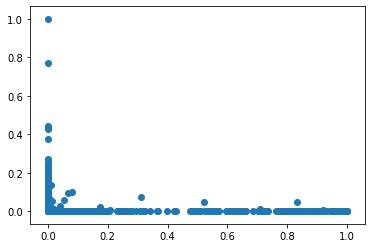

In [167]:
plt.scatter(adj_hat.flatten(), adjacency_true.flatten())

In [181]:
mean_rank_corr, rank_corr_per_dim = tsvar.utils.metrics.mean_kendall_rank_corr(
    adj_hat.flatten(), adjacency_true.flatten(), return_vec=True)

In [182]:
mean_rank_corr

-0.039862506938532154

(array([ 6., 17., 24., 15., 12.,  7.,  8.,  4.,  3.,  4.]),
 array([-0.16471, -0.13208, -0.09946, -0.06683, -0.0342 , -0.00158,  0.03105,  0.06367,  0.0963 ,  0.12893,  0.16155]),
 <a list of 10 Patch objects>)

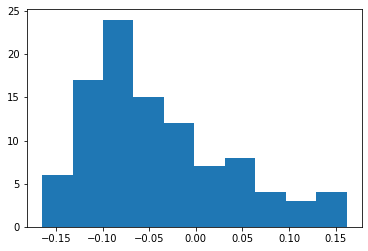

In [183]:
plt.hist(rank_corr_per_dim)

In [172]:
from scipy.stats import kendalltau

# calculate kendall's correlation
coef, p = kendalltau(
    x=adj_hat.flatten(),
    y=adjacency_true.flatten()
)

print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: -0.032
Samples are correlated (reject H0) p=0.001


---

## Exploration of results

In [167]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]
adj_hat

array([[0.00141, 0.00181, 0.00855, ..., 0.00943, 0.00923, 0.01304],
       [0.00311, 0.00129, 0.01251, ..., 0.00915, 0.00726, 0.01185],
       [0.00343, 0.00186, 0.04852, ..., 0.0099 , 0.00796, 0.01432],
       ...,
       [0.02883, 0.01501, 0.01245, ..., 0.00958, 0.01153, 0.02437],
       [0.01216, 0.00995, 0.00887, ..., 0.03078, 0.01442, 0.02328],
       [0.00137, 0.00276, 0.00194, ..., 0.0191 , 0.01991, 0.01562]])

In [168]:
adj_hat.nonzero()

(array([  0,   0,   0, ..., 622, 622, 622]),
 array([  0,   1,   2, ..., 620, 621, 622]))

In [170]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]

thresh_list = np.linspace(0.01, 0.15, 20)

vals_vifb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0
    print(np.round(thresh, 3), len(adj_hat_thresh.nonzero()[0]))

    for k in [5, 10, 20]:
        vals_vifb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

0.01 68288
0.017 31004
0.025 17360
0.032 11503
0.039 8389
0.047 6450
0.054 5161
0.062 4092
0.069 3304
0.076 2612
0.084 2068
0.091 1641
0.098 1313
0.106 912
0.113 804
0.121 720
0.128 658
0.135 604
0.143 551
0.15 516


In [159]:
thresh_list = np.linspace(0.01, 0.15, 20)

vals_gb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0

    for k in [5, 10, 20]:
        vals_gb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

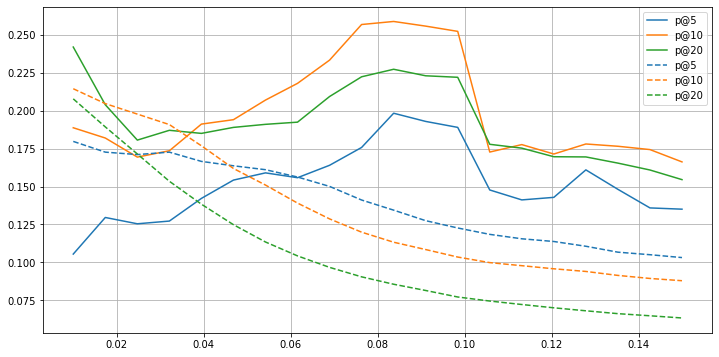

In [161]:
plt.figure(figsize=(12, 6))
plt.grid()

plt.plot(thresh_list, vals_vifb[5], label='p@5')
plt.plot(thresh_list, vals_vifb[10], label='p@10')
plt.plot(thresh_list, vals_vifb[20], label='p@20')

plt.plot(thresh_list, vals_gb[5],   label='p@5', c='C0', ls='--')
plt.plot(thresh_list, vals_gb[10], label='p@10', c='C1', ls='--')
plt.plot(thresh_list, vals_gb[20], label='p@20', c='C2', ls='--')

plt.legend();